In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

# Load data SQL

In [2]:
def load_sql(query: str) -> pd.DataFrame:
    load_dotenv()
    db_user= os.getenv("DB_USER")
    db_password= os.getenv("DB_PASSWORD")
    db_host= os.getenv("DB_HOST")
    db_name= os.getenv("DB_NAME")
    engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}')
    with engine.connect() as conn:
        df = pd.read_sql_query(text(query), conn)
        return df

pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = load_sql("SELECT * FROM raw.pharmacy_sales;")
df = df.sort_values(by=["distributor", "product_name", "year", "city", "month"])
df.head()

,distributor,customer_name,city,country,latitude,longitude,channel,sub_channel,product_name,product_class,quantity,price,sales,month,year,sales_rep_name,manager,sales_team
207687,Bashirian-Kassulke,Rogahn-Klein Pharma Plc,Leinfelden-Echterdingen,Germany,48.69,9.14,Pharmacy,Institution,Abatatriptan,Antibiotics,2.00,742.00,1484.00,February,2020,Stella Given,Alisha Cordwell,Charlie
187350,Bashirian-Kassulke,Runolfsson-Halvorson Pharm,Rheinberg,Germany,51.55,6.60,Pharmacy,Retail,Abranatal Lysoprosate,Antiseptics,15826.00,681.00,10777506.00,August,2019,Mary Gerrard,Britanny Bold,Delta
254078,Bashirian-Kassulke,Hane Ltd Pharmaceutical Ltd,Aichach,Germany,48.45,11.13,Hospital,Private,Abranatal Lysoprosate,Antiseptics,432.00,681.00,294192.00,December,2020,Anne Wu,Britanny Bold,Delta
175417,Bashirian-Kassulke,Doyle-Tillman Pharmaceutical Limited,Zirndorf,Germany,49.45,10.95,Pharmacy,Institution,Acantaine,Antibiotics,50.00,66.00,3300.00,June,2019,Thompson Crawford,James Goodwill,Alfa
246485,Bashirian-Kassulke,"Langworth, Olson and Satterfield Pharmacy",Meschede,Germany,51.35,8.28,Hospital,Government,Aciprex,Antipiretics,150.00,421.00,63150.00,November,2020,Thompson Crawford,James Goodwill,Alfa


In [3]:
df[['quantity', 'sales']].head(10)

,quantity,sales
207687,2.00,1484.00
187350,15826.00,10777506.00
254078,432.00,294192.00
175417,50.00,3300.00
246485,150.00,63150.00
232401,20.00,8420.00
53000,2500.00,1695000.00
254079,320.00,216960.00
158400,60.00,1440.00
188559,2000.00,48000.00


# Feature Engineering

In [4]:
features = (df.groupby(["distributor",
                    "channel",
                    "sub_channel",
                    "city",
                    "product_name",
                    "product_class",
                    "sales_team",
                    "year",
                    "month",]).agg(
                total_quantity=("quantity", "sum"),
                total_sales=("sales", "sum"),
                avg_price=("price", "mean"),
                    ).reset_index())

# Clean outliers
sales_upper_bound = features["total_sales"].quantile(0.90)
features["total_sales_clean"] = features["total_sales"].clip(lower=0, upper=sales_upper_bound)

# Split data

In [5]:
# Convert month to digit
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Time feature engineering for sorting and splitting by time
features["year"] = features["year"].astype(int)
features["month"] = features["month"].map(month_mapping)

features = features.sort_values(by=["distributor", "year", "month"])

# Function to split data by time
def time_split(df, split_date=(2018, 9)):
    train = df[
        (df["year"] < split_date[0]) |
        ((df["year"] == split_date[0]) & (df["month"] < split_date[1]))
    ].copy()
    test = df[
        (df["year"] > split_date[0]) |
        ((df["year"] == split_date[0]) & (df["month"] >= split_date[1]))
    ].copy()
    return train, test

train_raw, test_raw = time_split(features)

# Feature engineering

In [6]:
# Function to create lag features as new dataframe
def lag_features(df, is_train=True):
    df = df.copy()

    # Sort values
    df = df.sort_values(by=["distributor", "city", "year", "month"])
    grp = df.groupby(["distributor", "product_name", "city"]) # Factor effect on lag features

    # Lag features - use values from previous months as sales past ago
    df["lag_1m_sales"] = grp["total_sales_clean"].shift(1)
    df["lag_3m_sales"] = grp["total_sales_clean"].shift(3)
    df["lag_6m_sales"] = grp["total_sales_clean"].shift(6)

    # Rolling features
    df["rolling_avg_3m"] = grp["total_sales_clean"].transform(
        lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
    )
    df["rolling_avg_6m"] = grp["total_sales_clean"].transform(
        lambda x: x.shift(1).rolling(window=6, min_periods=1).mean()
    )
    # Growth percentage
    df["sales_growth_pct"] = grp["total_sales_clean"].transform(
        lambda x: x.pct_change().shift(1) * 100
    )

    # Seasonal features (month encoding)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # Clean NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)

    return df

train_fe = lag_features(train_raw, is_train=True)
test_fe = lag_features(test_raw, is_train=False)

# Verify values
print("Check for data leakage:")
print(f"Train date range: {train_fe['year'].min()}-{train_fe['month'].min()} to {train_fe['year'].max()}-{train_fe['month'].max()}")
print(f"Test date range: {test_fe['year'].min()}-{test_fe['month'].min()} to {test_fe['year'].max()}-{test_fe['month'].max()}")
print(f"\nTrain shape: {train_fe.shape}")
print(f"Test shape: {test_fe.shape}")

# Validate no data leakage
print("\nValidating no data leakage...")
print(train_fe[["year", "month", "total_sales_clean", "lag_1m_sales", "rolling_avg_3m"]].tail(10))

Check for data leakage:
Train date range: 2017-1 to 2018-12
Test date range: 2018-1 to 2020-12

Train shape: (118439, 21)
Test shape: (135203, 21)

Validating no data leakage...
        year  month  total_sales_clean  lag_1m_sales  rolling_avg_3m
253628  2017      9           76800.00          0.00            0.00
253630  2018      5           14840.00          0.00            0.00
253627  2018      6           26880.00          0.00            0.00
253629  2018      8              41.00          0.00            0.00
253634  2017      8             820.00          0.00            0.00
253631  2017     10             300.00          0.00            0.00
253633  2017     10           14712.00          0.00            0.00
253635  2018      5            1002.00          0.00            0.00
253638  2018      6           76800.00          0.00            0.00
253641  2018      7            4136.00          0.00            0.00


# Data Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["distributor", "channel", "sub_channel", "city", 
                    "product_name", "product_class", "sales_team"]

# Inisialisasi dictionary untuk menyimpan encoder
encoders = {}

# Fit encoder only on train,  transform train dan test
for col in categorical_cols:
    le = LabelEncoder()
    train_fe[col] = le.fit_transform(train_fe[col].astype(str))
    
    # Untuk test, handle unseen labels
    test_fe[col] = test_fe[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    encoders[col] = le

# Prepare final features

In [ ]:
final_features = ["distributor", "avg_price", "month", "year", 
    "product_class", "city", "lag_1m_sales", "rolling_avg_3m", "month_sin", "month_cos"]

X_train = train_fe[final_features]
y_train = train_fe["total_sales_clean"]

X_test = test_fe[final_features]
y_test = test_fe["total_sales_clean"]

# Filter out zero values for preventing MAPE ekstrem
mask = (y_test > 1000) & (y_test < 200000)
X_test_filtered = X_test[mask]
y_test_filtered = y_test[mask]

print(f"Original test samples: {len(y_test)}")
print(f"Filtered test samples: {len(y_test_filtered)}")
print(f"Filtered test y range: {y_test_filtered.min():.2f} - {y_test_filtered.max():.2f}")

Original test samples: 135203
Filtered test samples: 113171
Filtered test y range: 1002.00 - 76800.00


# Scaling

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_filtered)

X_train_df = pd.DataFrame(X_train_scaled, columns=final_features, index=X_train.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=final_features, index=X_test_filtered.index)

# Allign y_train with X_train_df index
y_train_aligned = y_train.loc[X_train_df.index]

print(f"X_train shape: {X_train_df.shape}")
print(f"y_train shape: {y_train_aligned.shape}")
print(f"X_test shape: {X_test_df.shape}")
print(f"y_test shape: {y_test_filtered.shape}")

X_train shape: (118439, 10)
y_train shape: (118439,)
X_test shape: (113171, 10)
y_test shape: (113171,)


In [ ]:
# Bandingkan scaling pada kolom avg_price
from sklearn.preprocessing import StandardScaler, RobustScaler

# Sample data
sample_data = train_fe[["total_sales_clean"]].head(10000)

# StandardScaler
std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(sample_data)

# RobustScaler
rob_scaler = RobustScaler()
rob_scaled = rob_scaler.fit_transform(sample_data)

# Compare
comparison = pd.DataFrame({
    "Original": sample_data["total_sales_clean"].values,
    "StandardScaler": std_scaled.flatten(),
    "RobustScaler": rob_scaled.flatten()
})

print(comparison.describe())

       Original  StandardScaler  RobustScaler
count  10000.00        10000.00      10000.00
mean   22936.24           -0.00          0.41
std    26532.21            1.00          0.84
min        0.00           -0.86         -0.32
25%     3070.00           -0.75         -0.23
50%    10200.00           -0.48          0.00
75%    34503.75            0.44          0.77
max    76800.00            2.03          2.12


# Training & Evaluation Machine learning models

In [ ]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

models = {
    "Ridge Regression": Ridge(alpha=10.0),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=300, learning_rate=0.5, max_depth=5, random_state=42),
    "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=200, subsample=0.8, colsample_bytree=0.8),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=300, random_state=42, max_depth=15, min_samples_leaf=10, n_jobs=-1),
    "CatBoost Regressor": CatBoostRegressor(iterations=300, depth=6, learning_rate=0.05, verbose=0, random_state=42),
    "LightGBM Regressor": LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, verbose=0)
}

def evaluate_model(y_true, y_pred):
    y_pred_clipped = np.clip(y_pred, 0, None)
    
    mae = mean_absolute_error(y_true, y_pred_clipped)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_clipped))
    r2 = r2_score(y_true, y_pred_clipped)
    
    # Hitung MAPE secara manual untuk kontrol lebih baik
    mape = np.mean(np.abs((y_true - y_pred_clipped) / y_true)) * 100
    
    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2,
        "MAPE (%)": mape
    }

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_df, y_train_aligned)
    y_pred = model.predict(X_test_df)
    results[model_name] = evaluate_model(y_test_filtered, y_pred)

results_df = pd.DataFrame(results).T.sort_values(by="R2 Score", ascending=False)
print(f"\nResults (Fixed):\n{results_df.to_string()}")

Training Ridge Regression...
Training Gradient Boosting Regressor...
Training XGBoost Regressor...
Training Random Forest Regressor...
Training CatBoost Regressor...
Training LightGBM Regressor...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

# Deep diagnostic

In [ ]:
# ========================================
# CELL BARU: DEEP DIAGNOSTIC
# ========================================

print("="*80)
print("DEEP DIAGNOSTIC ANALYSIS")
print("="*80)

# 1. Cek apakah lag features benar-benar ada
print("\n1. LAG FEATURES STATISTICS:")
print("-"*80)
lag_stats = train_fe[["lag_1m_sales", "lag_3m_sales", "rolling_avg_3m"]].describe()
print(lag_stats)

# Cek berapa persen yang 0
print("\nPercentage of zeros in lag features:")
for col in ["lag_1m_sales", "lag_3m_sales", "rolling_avg_3m"]:
    zero_pct = (train_fe[col] == 0).sum() / len(train_fe) * 100
    print(f"  {col}: {zero_pct:.1f}%")

# 2. Cek korelasi antara features dan target
print("\n2. CORRELATION WITH TARGET:")
print("-"*80)
corr_cols = ["lag_1m_sales", "lag_3m_sales", "rolling_avg_3m", "avg_price", "month"]
correlations = train_fe[corr_cols + ["total_sales_clean"]].corr()["total_sales_clean"].sort_values(ascending=False)
print(correlations)

# 3. Sample data untuk validasi visual
print("\n3. SAMPLE DATA VALIDATION (per distributor-product-city):")
print("-"*80)
sample = train_fe.groupby(["distributor", "product_name", "city"]).head(12)
print(sample[["distributor", "product_name", "city", "year", "month", 
              "total_sales_clean", "lag_1m_sales", "rolling_avg_3m"]].head(30).to_string())

# 4. Cek distribusi train vs test
print("\n4. TRAIN vs TEST DISTRIBUTION:")
print("-"*80)
print(f"Train y mean: {y_train.mean():,.2f}, std: {y_train.std():,.2f}")
print(f"Test y mean: {y_test_filtered.mean():,.2f}, std: {y_test_filtered.std():,.2f}")
print(f"Ratio (test/train mean): {y_test_filtered.mean() / y_train.mean():.2f}")

# 5. Cek feature importance dengan simple model
print("\n5. QUICK FEATURE IMPORTANCE TEST:")
print("-"*80)
from sklearn.ensemble import RandomForestRegressor
simple_rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
simple_rf.fit(X_train_df.head(10000), y_train_aligned.head(10000))  # Sample untuk cepat

feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': simple_rf.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.to_string())

# 6. Prediksi baseline (mean predictor)
print("\n6. BASELINE COMPARISON:")
print("-"*80)
baseline_pred = np.full(len(y_test_filtered), y_train.mean())
baseline_r2 = r2_score(y_test_filtered, baseline_pred)
baseline_mae = mean_absolute_error(y_test_filtered, baseline_pred)
print(f"Baseline (mean) R²: {baseline_r2:.3f}")
print(f"Baseline MAE: {baseline_mae:,.2f}")
print(f"Your best model R²: 0.005")
print(f"→ Model is {'BETTER' if 0.005 > baseline_r2 else 'WORSE'} than baseline!")

DEEP DIAGNOSTIC ANALYSIS

1. LAG FEATURES STATISTICS:
--------------------------------------------------------------------------------
       lag_1m_sales  lag_3m_sales  rolling_avg_3m
count     118439.00     118439.00       118439.00
mean        1396.65          9.70         1395.57
std         8081.03        663.71         7964.15
min            0.00          0.00            0.00
25%            0.00          0.00            0.00
50%            0.00          0.00            0.00
75%            0.00          0.00            0.00
max        76800.00      76800.00        76800.00

Percentage of zeros in lag features:
  lag_1m_sales: 90.9%
  lag_3m_sales: 99.9%
  rolling_avg_3m: 90.9%

2. CORRELATION WITH TARGET:
--------------------------------------------------------------------------------
total_sales_clean   1.00
avg_price           0.28
month               0.04
rolling_avg_3m      0.01
lag_1m_sales        0.01
lag_3m_sales        0.00
Name: total_sales_clean, dtype: float64

3. SAMPL

# Data visualization

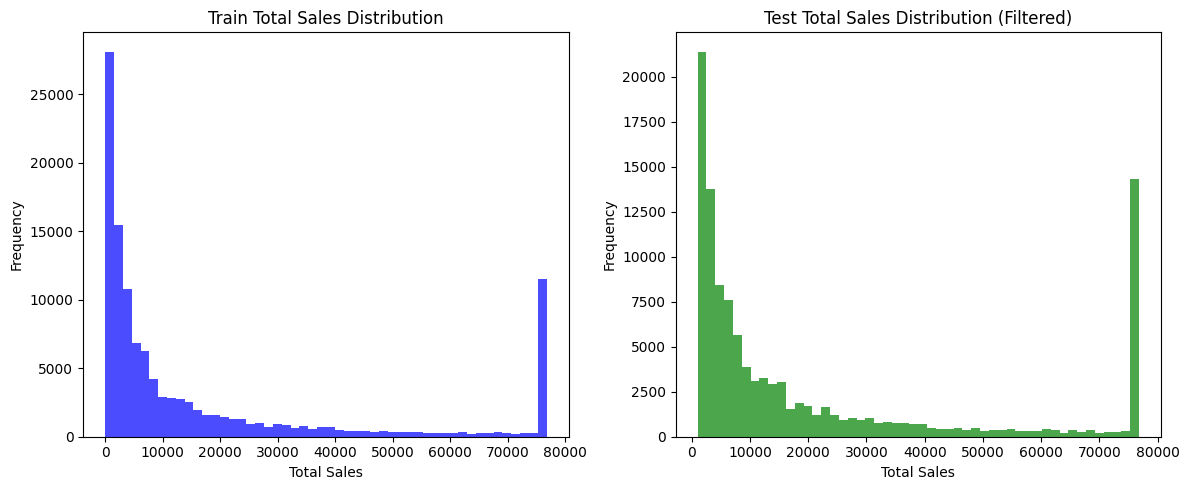

In [ ]:
import matplotlib.pyplot as plt

# Train distribution plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(y_train_aligned, bins=50, color='blue', alpha=0.7)
ax[0].set_title('Train Total Sales Distribution')
ax[0].set_xlabel('Total Sales')
ax[0].set_ylabel('Frequency')

# Test distribution plot
ax[1].hist(y_test_filtered, bins=50, color='green', alpha=0.7)
ax[1].set_title('Test Total Sales Distribution (Filtered)')
ax[1].set_xlabel('Total Sales')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()